<div>
  <img style="float: left;"  width="140" src=" 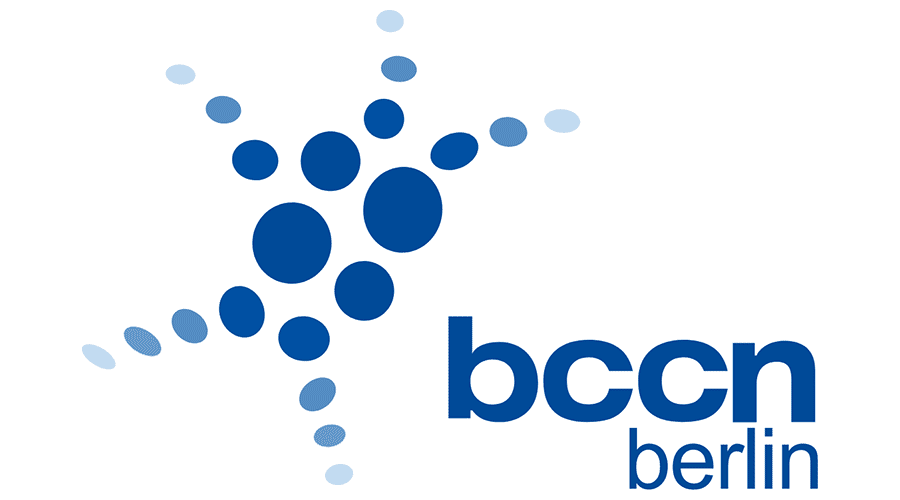">
</div>

<h1 id="course-title-heading">
    <div style="text-align: right">
        Computational Modeling Practical Course
        <br>
    </div>
</h1>

<div style="text-align: left; float: left">
    Bernstein Center for Computational Neuroscience Berlin
    <br>Lecturer: Prof. Dr. Henning Sprekeler
    <br>Tutor: Simone Ciceri
</div>

<br>
<h1>
<br>
<br>Final Project
</h1>

<div style="text-align: left">
    Gerardo Parra
</div>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

from models import *
from utils import *
from plots import *

# Universal variables
METHOD  = 'RK45' #'RK23' #'DOP853' #'LSODA' #'Radau' #'BDF'
T0      = 24.5
TAU_T   = 24

# Simulation parameters 
y0 = [T0]
n_days = 15
t_span = (0, n_days*24)
t_eval = np.arange(t_span[0], t_span[1], 0.05)
days   = np.arange(t_span[0], t_span[1]+1, 24)

## 1. Circadian rhythm

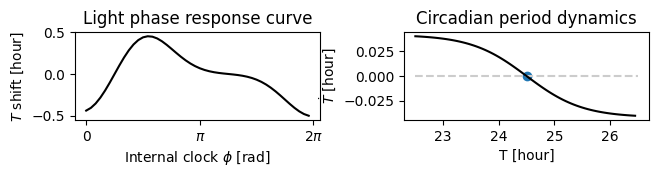

In [3]:
# Plot system components
fig, ax = plt.subplots(1, 2, figsize=(7,2))
fig.tight_layout(pad=3)
# Plot phase response curve
day = np.arange(0, 24, 0.5)
ax[0].plot(phi(day,24), PRC(phi(day,24)), 'k')
ax[0].set_xlabel(r'Internal clock $\phi$ [rad]'), ax[0].set_ylabel(r'$T$ shift [hour]')
ax[0].set_xticks([0,np.pi,2*np.pi],['0',r'$\pi$',r'$2\pi$'])
ax[0].set_title('Light phase response curve')

# Plot dT(T)
T = np.arange(T0-2,T0+2,0.05)
ax[1].hlines(0, T0-2, T0+2, '#ccc', '--')
ax[1].plot(T, dT(T, mu=T0, tau=TAU_T), 'k'), ax[1].scatter(T0,0)
ax[1].set_xlabel('T [hour]'), ax[1].set_ylabel(r'$\dot{T}$ [hour]')
ax[1].set_title('Circadian period dynamics')
plt.show()

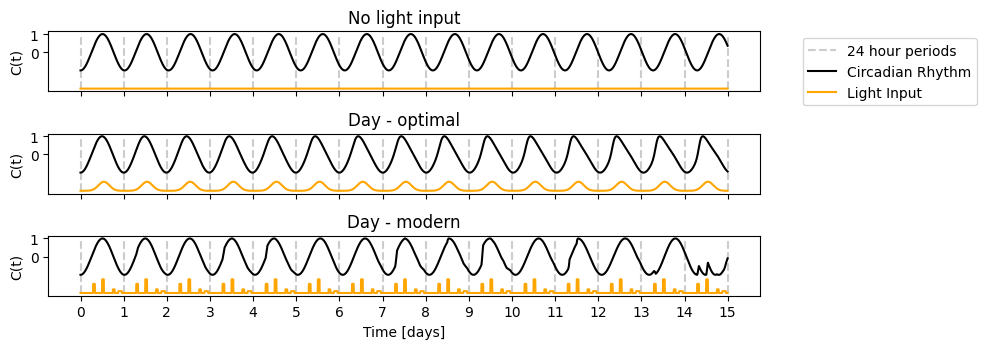

In [4]:
params_circadian = {
    'alpha': 2,
    'mu': T0,
    'tau': 48 #TAU_T
}
conditions_circadian = {
    'No light input':     {'hours': [], 'amp': 1, 'L': input_daily},
    'Day - optimal':      {'center': 13, 'amp': 0.5, 'width': 3, 'L': input_daily_smooth},
    'Day - modern':       {'hours': [(7,8),(12,13),(18,19),(21,23)], 'amp': [0.5, 0.75, 0.2, 0.1], 'L': input_daily},
    # 'Winter':             {'hours': [(8,9),(12,13),(18,22)], 'amp': [0.1, 0.25, 0.05], 'L': input_daily},
    # 'Winter - SAD lamp':  {'hours': [(7.5,8),(8,9),(12,13),(18,22)], 'amp': [0.75,0.1, 0.25, 0.05], 'L': input_daily},
    # 'Night - excessive':  {'hours': [(20,24),(0,5)], 'amp': 1, 'L': input_daily},
    # 'Day - excessive':    {'hours': [(7,17)], 'amp': 1, 'L': input_daily},
}
n_cond = len(conditions_circadian)

## Solve and plot solutions
fig, ax = plt.subplots(n_cond, 1, figsize=(10, 1.2*n_cond), sharex=True) 
solutions = []
for i, cond in enumerate(conditions_circadian.keys()):
    # Solve
    params_i = params_circadian
    params_i['light'] = conditions_circadian[cond]
    solutions.append(solve_ivp(circadian, t_span, y0, args=(params_i,), t_eval=t_eval, method=METHOD, rtol=1e-8, atol=1e-10))
    # Plot
    plot_days(days, ax[i], amp=(-2,1))
    plot_circadian(solutions[i], ax=ax[i])
    ax[i].plot(solutions[i].t, params_i['light']['L'](solutions[i].t, params_i['light']) - 2, label="Light Input", color="orange")
    ax[i].set_title(cond)
    ax[i].set_yticks([0, 1])
ax[0].legend(['24 hour periods',"Circadian Rhythm", "Light Input"], loc="upper left", bbox_to_anchor=(1.05, 1))
plt.xlabel('Time [days]'), set_day_xticks(t_span)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

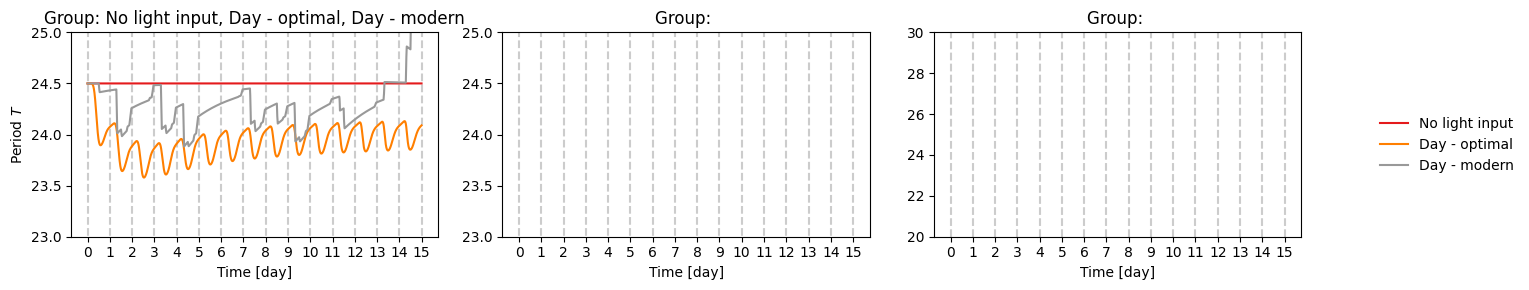

In [5]:
# Define condition groups
condition_names = list(conditions_circadian.keys())
group1 = condition_names[:3]
group2 = condition_names[3:5]
group3 = condition_names[5:]
colors = plt.get_cmap('Set1', len(condition_names))
groups = [group1, group2, group3]

# Loop over each subplot group
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for ax, group in zip(axes, groups):
    plot_days(days, amp=(20, 30), ax=ax)
    for cond in group:
        idx = condition_names.index(cond)
        ax.plot(solutions[idx].t, solutions[idx].y[0], label=cond, color=colors(idx))
    ax.set_xlabel('Time [day]')
    set_day_xticks(t_span, ax=ax)
    ax.set_ylim(23, 25)
    ax.set_title(f'Group: {", ".join(group)}')
axes[0].set_ylabel(r'Period $T$')
axes[-1].set_ylim(20,30)

# Single unified legend
handles = [plt.Line2D([], [], color=colors(i), label=name) for i, name in enumerate(condition_names)]
fig.legend(handles, condition_names, loc="center right", bbox_to_anchor=(1.1, 0.5), frameon=False)

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

## 2. Sleep

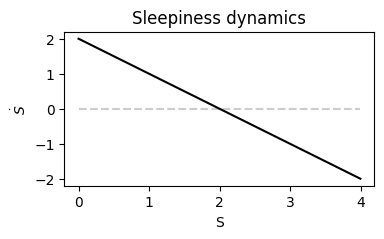

In [6]:
# Plot Sleepiness dynamics
plt.figure(figsize=(4,2))
S_states = np.arange(0, 4, 0.01)
plt.hlines(0, 0, S_states[-1], '#ccc', '--')
plt.plot(S_states, dS(S_states, 1), 'k')
plt.xlabel('S'), plt.ylabel(r'$\dot{S}$')
plt.title('Sleepiness dynamics')

plt.show()

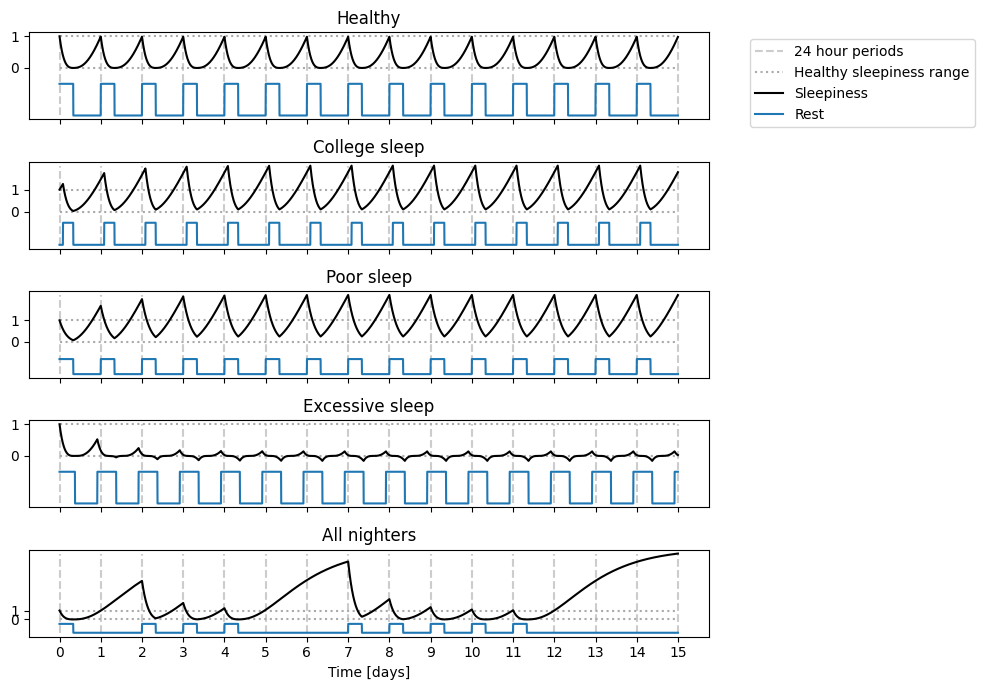

In [7]:
params_sleep = {
    'S0':    [1],
    'tau_S': 24,
    'tau_R': 5.5,
}
conditions_sleep = {
    'Healthy': {'hours': [(0,8)], 'amp': 1, 'R': input_daily},
    'College sleep': {'hours': [(2,8)], 'amp': 1, 'R': input_daily},
    'Poor sleep': {'hours': [(0,8)], 'amp': 0.7, 'R': input_daily},
    'Excessive sleep': {'hours': [(22,24),(0,9)], 'amp': [1,1], 'R': input_daily},
    'All nighters': {'hours': [[(0,8)],[],[(0,8)],[(0,8)],[(0,8)],[],[],[(0,8)],[(0,8)],[(0,8)],[(0,8)],[(0,8)]], 'amp': [[1] for _ in range(12)], 'R': input_variable}
}
n_cond = len(conditions_sleep.keys())

## Solve and plot sleep solutions
fig, ax = plt.subplots(n_cond, 1, figsize=(10, 1.4*n_cond), sharex=True)
solutions = []
for i, cond in enumerate(conditions_sleep.keys()):
    # Solve
    params_i = params_sleep
    params_i['rest'] = conditions_sleep[cond]
    solutions.append(solve_ivp(sleep, t_span, params_sleep['S0'], args=(params_i,), t_eval=t_eval, rtol=1e-8, atol=1e-10))
    # Plot
    plot_days(days, ax[i], amp=(-1.5, solutions[i].y[0].max()**3))
    ax[i].hlines([0,1], 0, t_span[-1], '#aaa', ':')
    ax[i].plot(solutions[i].t, f_S(solutions[i].y[0]), 'k', label='Sleepiness')
    ax[i].plot(solutions[i].t, params_i['rest']['R'](solutions[i].t, params_i['rest']) - 1.5, label="Rest")
    ax[i].set_title(cond)
    ax[i].set_yticks([0, 1])
ax[0].legend(['24 hour periods','Healthy sleepiness range','Sleepiness','Rest'], loc="upper left", bbox_to_anchor=(1.05, 1))
ax[-1].set_xlabel('Time [days]'), set_day_xticks(t_span)
fig.tight_layout()
plt.show()

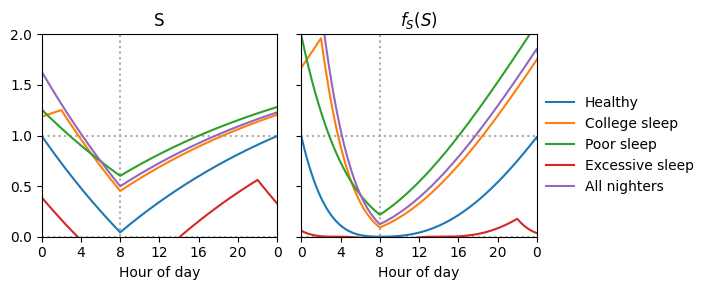

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

# Define x-limits and compute custom x-ticks and labels
xlims = (48, 72)
xticks = np.arange(xlims[0], xlims[1]+1, 4)  # every 4 hours
xtick_labels = [str(int(t % 24)) for t in xticks]

# Color cycle so both plots use the same colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# --- Left subplot ---
axes[0].hlines([0, 1], *xlims, color='#aaa', linestyles=':')
axes[0].vlines([56], -1, 2, color='#aaa', linestyles=':')
for i, cond in enumerate(conditions_sleep.keys()):
    axes[0].plot(solutions[i].t, solutions[i].y[0], label=cond, color=colors[i])
axes[0].set_xlim(*xlims)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xtick_labels)
axes[0].set_title("S")
axes[0].set_xlabel("Hour of day")

# --- Right subplot ---
axes[1].hlines([0, 1], *xlims, color='#aaa', linestyles=':')
axes[1].vlines([56], -1, 2, color='#aaa', linestyles=':')
for i, cond in enumerate(conditions_sleep.keys()):
    axes[1].plot(solutions[i].t, f_S(solutions[i].y[0]), label=cond, color=colors[i])
axes[1].set_xlim(*xlims)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xtick_labels)
axes[1].set_ylim(0, 2)
axes[1].set_title(r'$f_S(S)$')
axes[1].set_xlabel("Hour of day")

# Single legend outside
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5), frameon=False)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space on right for legend
plt.show()


## 3. Combine model components

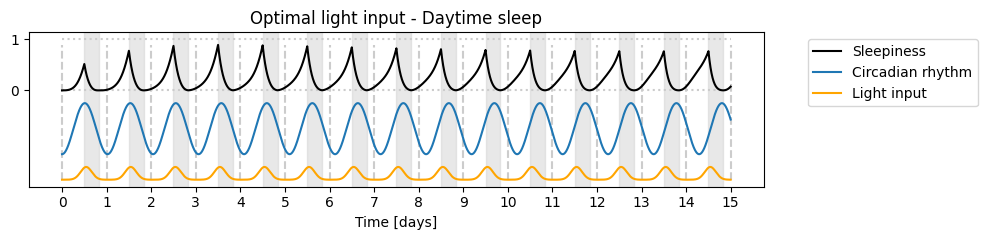

In [19]:
light_opt     = {'title': 'Optimal light input', 'light': {'center': 13, 'amp': 0.5, 'width': 3, 'L': input_daily_smooth}}
light_modern  = {'title': 'Modern work day', 'light': {'hours': [(7,8),(12,13),(18,19),(21,23)], 'amp': [0.5, 0.75, 0.2, 0.1], 'L': input_daily}}
light_winter  = {'title': 'Winter light', 'light': {'hours': [(8,9),(12,13),(18,22)], 'amp': [0.1, 0.25, 0.05], 'L': input_daily}}
light_summer  = {'title': 'Summer light', 'light': {'center': 13, 'amp': 0.75, 'width': 4, 'L': input_daily_smooth}}
light_none    = {'title': 'No light', 'light': {'hours': [], 'amp': 0, 'L': input_daily}}
sleep_opt     = {'title': 'Optimal sleep', 'rest': {'hours': [(0, 8)], 'amp': 1, 'R': input_daily}}
sleep_college = {'title': 'Delayed, short sleep', 'rest': {'hours': [(2, 8)], 'amp': 1, 'R': input_daily}}
sleep_late    = {'title': 'Delayed, sufficient sleep', 'rest': {'hours': [(2, 9.5)], 'amp': 1, 'R': input_daily}}
sleep_winter  = {'title': 'Optimal sleep, early', 'rest': {'hours': [(23,24), (0,8)], 'amp': 1, 'R': input_daily}}
all_nighter   = {'title': 'All nighter', 'rest': {'hours': [[]] + [[(0,8)] for _ in range(n_days-1)], 'amp': [[1] for _ in range(n_days)], 'R': input_variable}}
sleep_daytime = {'title': 'Daytime sleep', 'rest': {'hours': [(12,20)], 'amp': 1, 'R': input_daily}}

params_energy = {
    'C': {
        'alpha': 2, #3,
        'mu': T0,
        'tau': 48, #TAU_T,
        'light_conditions': [
            # light_opt, light_modern, light_opt, light_opt, light_winter, light_none, light_summer, light_opt, 
            light_opt]
    },
    'S': {
        'tau_S': 24,
        'tau_R': 5.5,
        'rest_conditions': [
            # sleep_opt, sleep_opt, sleep_college, sleep_late, sleep_winter, sleep_opt, sleep_opt, all_nighter, 
            sleep_daytime]
    }
}

y0 = [T0, 0]
plot_energy_conditions(params_energy, t_span, t_eval, y0, days)